In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../raw_data/clean_dataset_1.csv').drop('Unnamed: 0', axis = 1)

In [3]:
df.head()

,Reviewer_Score,Review_Text,reviews
0,2.9,i am so angry that i made this post available...,i am so angry that i made this post available ...
1,7.5,no real complaints the hotel was great great...,no real complaint the hotel wa great great loc...
2,7.1,rooms are nice but for elderly a bit difficul...,room are nice but for elderly a bit difficult ...
3,3.8,my room was dirty and i was afraid to walk ba...,my room wa dirty and i wa afraid to walk baref...
4,6.7,you when i booked with your company on line y...,you when i booked with your company on line yo...


## df round to discrete numbers

In [4]:
df['review_score'] = np.round((df['Reviewer_Score']*2)/2, decimals = 0).astype(np.int8)
df = df.drop('Reviewer_Score', axis = 1)

In [5]:
df.head()

,Review_Text,reviews,review_score
0,i am so angry that i made this post available...,i am so angry that i made this post available ...,3
1,no real complaints the hotel was great great...,no real complaint the hotel wa great great loc...,8
2,rooms are nice but for elderly a bit difficul...,room are nice but for elderly a bit difficult ...,7
3,my room was dirty and i was afraid to walk ba...,my room wa dirty and i wa afraid to walk baref...,4
4,you when i booked with your company on line y...,you when i booked with your company on line yo...,7


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Review_Text   515738 non-null  object
 1   reviews       515493 non-null  object
 2   review_score  515738 non-null  int8  
dtypes: int8(1), object(2)
memory usage: 8.4+ MB


## df drop null

In [7]:
df = df.dropna()

## remove comments les than x words

In [8]:
def word_counter(X):
    return len(X.split(' '))

In [9]:
df['word_count'] = df['reviews'].apply(word_counter)

In [10]:
df = df[df['word_count']>9].reset_index().drop('index', axis = 1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400486 entries, 0 to 400485
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Review_Text   400486 non-null  object
 1   reviews       400486 non-null  object
 2   review_score  400486 non-null  int8  
 3   word_count    400486 non-null  int64 
dtypes: int64(1), int8(1), object(2)
memory usage: 9.5+ MB


## rebalance data

In [12]:
## create a list of unique y-values
df['review_score'].unique()

counts = df['review_score'].value_counts()

df['Counts'] = df['review_score'].map(counts)

df_more_than_xxx = df[df['Counts'] > 999]

unique_values = df_more_than_xxx['review_score'].unique()

In [13]:
## create a function to rebalance the data
def balance_df(lst, df):
    dict_dfs = {}
    
    for val in lst:
        df_val = df[df['review_score'] == val]
        
        dict_dfs[val] = df_val.sample(n=1000)
        
    return dict_dfs

In [14]:
## get the df's from the dict, merge and shuffle them

## get the the dict with the dfs inside
dct_dfs = balance_df(unique_values, df_more_than_xxx)

## concat the dfs
df_balanced_sorted = pd.concat(dct_dfs.values(), ignore_index=True)

## shuffle the rows of the df
df_balanced = df_balanced_sorted.sample(frac=1).reset_index(drop=True)

df_balanced

,Review_Text,reviews,review_score,word_count,Counts
0,the hotel is being fully refurbished and will...,the hotel is being fully refurbished and will ...,8,45,85874
1,d cor a bit dated could be modernised a bit c...,d cor a bit dated could be modernised a bit co...,10,25,137996
2,under staffed staff are willing to help but n...,under staffed staff are willing to help but ne...,5,273,20515
3,bathrooms oddly designed look good but sink t...,bathroom oddly designed look good but sink tap...,7,99,36034
4,hotel staff were friendly and food and drink...,hotel staff were friendly and food and drink w...,8,11,85874
...,...,...,...,...,...
8995,the room itself we can hear someone stepping ...,the room itself we can hear someone stepping a...,5,27,20515
8996,i booked a cabinn the room was very very smal...,i booked a cabinn the room wa very very small ...,2,103,1660
8997,it took us about minutes to get to amsterda...,it took u about minute to get to amsterdam cen...,9,35,83160
8998,situated on a quiet street so need to walk re...,situated on a quiet street so need to walk rea...,5,41,20515


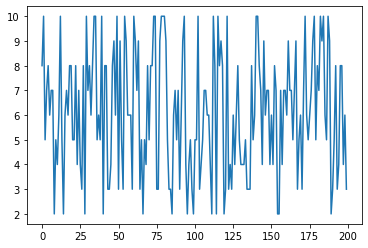

In [15]:
## show a part of the rebalanced df
plt.plot(np.arange(200), df_balanced['review_score'][:200])

In [16]:
## at this point we got 9000 rows

## definig y and x

In [17]:
# df_balanced = df[:100000]

In [18]:
# y = df_balanced['review_score']

## One hot encoded the lables

In [19]:
from sklearn.preprocessing import OneHotEncoder
y = df_balanced[['review_score']]

In [20]:
y_bin = OneHotEncoder().fit_transform(y).astype(np.int8)

In [21]:
pd.DataFrame(y_bin.toarray(), columns = [2, 3, 4, 5, 6, 7, 8, 9, 10]).shape

(9000, 9)

## split the data

In [22]:
X_train = df_balanced['reviews'][:6000]
X_test = df_balanced['reviews'][6000:]

y_train = y_bin[:6000].toarray()
y_test = y_bin[6000:].toarray()

## vectorizing und embedding

In [23]:
# –– Step #1
def convert_sentences(X):
    return [sentence.split(' ') for sentence in X]

X_train_words = convert_sentences(X_train)
X_test_words = convert_sentences(X_test)

In [24]:
# –– Step #2
from gensim.models import Word2Vec
word2vec = Word2Vec(sentences=X_train, size=200, min_count=1, window=5)

In [25]:
# –– Step #3
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

In [26]:
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

In [27]:
X_train_embed = embedding(word2vec, X_train_words)
X_test_embed = embedding(word2vec, X_test_words)

## padding

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post')
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post')

In [29]:
X_train_pad.shape

(6000, 53, 200)

## Model

In [31]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(45, activation='relu'))
    model.add(layers.Dense(9, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

model = init_model()

In [33]:
X_train_pad_short = X_train_pad[:500] # These two lines are just to accelerate the cell run
y_train_short = y_train[:500]

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train_pad, y_train, 
          batch_size = 32,
          epochs=100,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/100
132/132 [==============================] - 5s 35ms/step - loss: 2.1616 - accuracy: 0.1448 - val_loss: 2.1650 - val_accuracy: 0.1328
Epoch 2/100
132/132 [==============================] - 4s 31ms/step - loss: 2.1588 - accuracy: 0.1512 - val_loss: 2.1653 - val_accuracy: 0.1378
Epoch 3/100
132/132 [==============================] - 4s 31ms/step - loss: 2.1577 - accuracy: 0.1464 - val_loss: 2.1642 - val_accuracy: 0.1456
Epoch 4/100
132/132 [==============================] - 4s 31ms/step - loss: 2.1560 - accuracy: 0.1469 - val_loss: 2.1680 - val_accuracy: 0.1433
Epoch 5/100
132/132 [==============================] - 4s 31ms/step - loss: 2.1562 - accuracy: 0.1486 - val_loss: 2.1640 - val_accuracy: 0.1294
Epoch 6/100
132/132 [==============================] - 4s 31ms/step - loss: 2.1530 - accuracy: 0.1552 - val_loss: 2.1666 - val_accuracy: 0.1439
Epoch 7/100
132/132 [==============================] - 4s 31ms/step - loss: 2.1509 - accuracy: 0.1505 - val_loss: 2.1661 - val_accuracy:

In [36]:
res = model.evaluate(X_test_pad, y_test, verbose=0)
res

## Prediction

In [46]:
sentence1 = "While am generally happy with their service, there is a push to take a considerable discount for a reservation that does not allow cancellations. The standard undiscounted price is about the same as booking directly with the option of cancellations. Using Booking.com is merely a convenience. The discount for forgoing cancellation needs to be comared with the cost of cancellation insurance. Even if one can't use the reservation because of government restrictions the hotels sock it to the customer for far more than their out of pocket costs since at worst they don't have to service the rooms and at best can re-rent them. Bottom line: Don't be taken in by Booking.com's apparently cheap nonrefundable offers."
sentence2 = "Great vacation until we tried to travel home. We tried calling and waited more than 2 hours for a callback and then they were unable/unwilling to help us. Stranded for 48 hours because of this company with no help rebooking flights. We are out for hotel, food, and time off work because I was hung up on repeatedly by their customer service department. Once I was finally home, they told me there's nothing they can do for me that they were really sorry all this happened. They were unwilling to make it right, but told me that I could have requested a refund for my flight home if I would have been able to reach them at the time."

In [47]:
lst = [sentence1, sentence2]

In [48]:
## convert into tokens
tokens = convert_sentences(lst)

## convert tokens into vectors
vectors = embedding(word2vec, tokens)

## padding the vectors
vectors_padding = pad_sequences(pred2, dtype='float32', padding='post')

## predict
prediction = model.predict(vectors_padding)

prediction